In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [22]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        print(s, 'current state')
        print(a, 'action')
        print(y, 'target')
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [23]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [24]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            # td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [25]:
estimator = Estimator()

In [26]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 1, epsilon=0.0)

[-0.51207213  0.        ] current state
0 action
-1.0 target
Step 0 @ Episode 1/1 (0.0)[-0.51315856 -0.00108643] current state
1 action
-1.0 target
Step 1 @ Episode 1/1 (0.0)[-0.51432328 -0.00116472] current state
2 action
-1.0 target
Step 2 @ Episode 1/1 (0.0)[-5.14557561e-01 -2.34278664e-04] current state
2 action
-1.046483168287532 target
Step 3 @ Episode 1/1 (0.0)[-0.51385964  0.00069792] current state
1 action
-1.0465077953385633 target
Step 4 @ Episode 1/1 (0.0)[-0.51323475  0.00062489] current state
0 action
-1.0466484245682826 target
Step 5 @ Episode 1/1 (0.0)[-5.13687583e-01 -4.52830233e-04] current state
1 action
-1.0932119328065597 target
Step 6 @ Episode 1/1 (0.0)[-0.51421474 -0.00052715] current state
2 action
-1.0931873430229744 target
Step 7 @ Episode 1/1 (0.0)[-5.13812260e-01  4.02475775e-04] current state
0 action
-1.0932179121145984 target
Step 8 @ Episode 1/1 (0.0)[-0.51448317 -0.00067091] current state
0 action
-1.1391890936112636 target
Step 9 @ Episode 1/1 (0.0)[-

Step 116 @ Episode 1/1 (0.0)[-0.50126695 -0.00118135] current state
0 action
-2.7920502831299348 target
Step 117 @ Episode 1/1 (0.0)[-0.50361566 -0.00234871] current state
1 action
-2.7935301286133067 target
Step 118 @ Episode 1/1 (0.0)[-0.50611415 -0.00249849] current state
2 action
-2.8053482633477946 target
Step 119 @ Episode 1/1 (0.0)[-0.50774372 -0.00162957] current state
0 action
-2.835313901571825 target
Step 120 @ Episode 1/1 (0.0)[-0.51049216 -0.00274844] current state
1 action
-2.8383871995509518 target
Step 121 @ Episode 1/1 (0.0)[-0.51333887 -0.00284671] current state
2 action
-2.853165784934911 target
Step 122 @ Episode 1/1 (0.0)[-0.51526252 -0.00192365] current state
0 action
-2.8797199256461847 target
Step 123 @ Episode 1/1 (0.0)[-0.51824868 -0.00298616] current state
1 action
-2.884395330708007 target
Step 124 @ Episode 1/1 (0.0)[-0.52127497 -0.00302629] current state
2 action
-2.9011156585704905 target
Step 125 @ Episode 1/1 (0.0)[-0.52331869 -0.00204372] current state

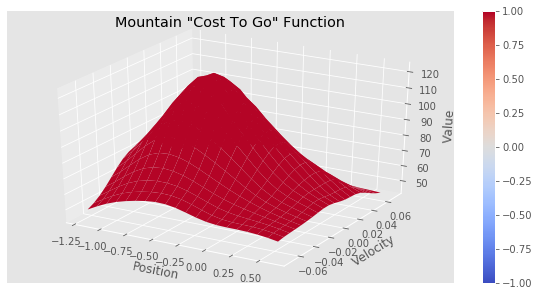

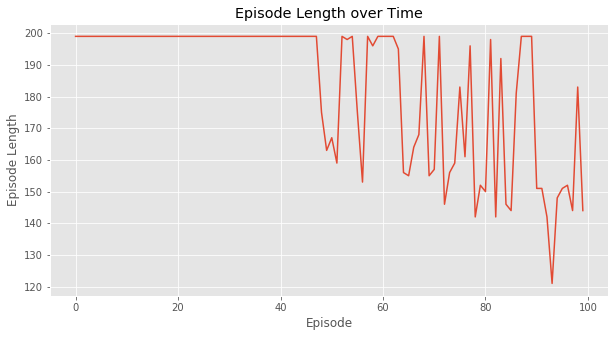

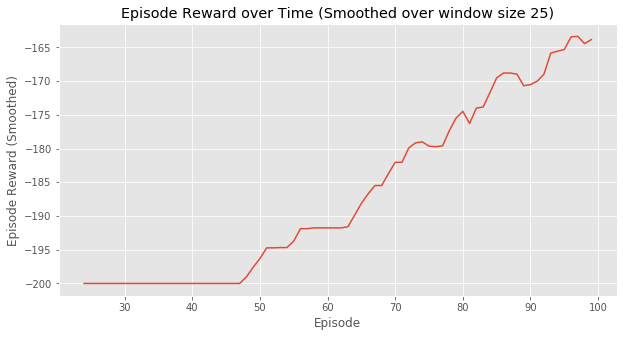

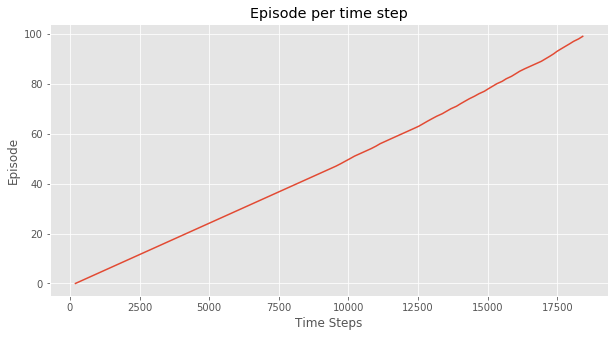

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [16]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)